<a href="https://colab.research.google.com/github/IdjiotSandwiches/face-emotion-recognition/blob/knn-model/machine-learning/knn-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install dagshub --quiet
!pip install mlflow --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.5/252.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.4/27.4 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/

In [58]:
import cv2 as cv
import numpy as np
import mlflow
import dagshub
import os
import pathlib
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pickle

In [2]:
PATH = pathlib.Path('C:\\Users\\vinar\\Downloads\\FER2013-augmented')
LABELS = os.listdir(PATH)

In [3]:
dagshub.init(repo_owner='IdjiotSandwiches', repo_name='face-emotion-recognition', mlflow=True)

Accessing as IdjiotSandwiches

Initialized MLflow to track repo "IdjiotSandwiches/face-emotion-recognition"

Repository IdjiotSandwiches/face-emotion-recognition initialized!

In [52]:
K_SIZE = (21,21)
SIGMA = 3
THETA_RANGE = np.arange(0, np.pi, np.pi/32)
LAMBD = 10.0
GAMMA = 0.5
PSI = 0
FLOATING_POINT = cv.CV_32F
IMAGE_SIZE = (224,224)
N_COMPONENTS = 0.95
N_COMPONENTS_LOCAL = 16
BLUR = (5,5)

gabor_params = {
    'ksize': K_SIZE,
    'sigma': SIGMA,
    'lambd': LAMBD,
    'gamma': GAMMA,
    'psi': PSI
}

KERNELS = [cv.getGaborKernel(**gabor_params, theta=theta) for theta in THETA_RANGE]

In [53]:
def gabor_filter(img):
  img = img.astype(np.float32)
  return np.array([cv.filter2D(img, FLOATING_POINT, kernel) for kernel in KERNELS])

In [54]:
def save_filtered_img(images, labels, path):
  folder_path = f'C:\\Users\\vinar\\Downloads\\gabor-filtered-imgs\\{path}'
  os.makedirs(folder_path, exist_ok=True)

  np.save(f'{folder_path}/images.npy', images)
  np.save(f'{folder_path}/labels.npy', labels)

  print('Ok!')

In [55]:
from joblib import Parallel, delayed

def process_image(img_path, label, dir):
    """
    Process a single image: read, preprocess, and apply PCA.
    """
    path = f'{dir}/{label}'
    img = cv.imread(f'{path}/{img_path}', 0)
    img = cv.resize(img, IMAGE_SIZE)
    img = cv.GaussianBlur(img, BLUR, 0)
    img = cv.equalizeHist(img)

    face_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(50, 50))

    if len(faces) > 0:
        x, y, w, h = faces[0]
        img = img[y:y+h, x:x+w]
    else:
        h, w = img.shape[:2]
        crop_size = min(h, w)
        x = (w - crop_size) // 2
        y = (h - crop_size) // 2
        img = img[y:y+crop_size, x:x+crop_size]
    
    img = cv.copyMakeBorder(
        img, 
        10, 10, 10, 10,
        cv.BORDER_CONSTANT, 
        value=(0, 0, 0)
    )
    
    img = cv.resize(img, IMAGE_SIZE)
    img = img / 255.0
    img = gabor_filter(img)

    img = img.reshape(img.shape[0], -1)
    pca = PCA(n_components=N_COMPONENTS_LOCAL)
    img = pca.fit_transform(img)

    folder_path = f'C:\\Users\\vinar\\Downloads\\gabor-filtered-imgs\\FER2013\\new\\{label}'
    os.makedirs(folder_path, exist_ok=True)
    img_path = img_path.split('.')
    np.save(f'{folder_path}/{img_path[0]}.npy', img)


def open_dataset(dir):
    """
    Open dataset, load images, preprocess, and return images and labels using parallel processing.
    """
    # Use Parallel from joblib to process images in parallel
    results = Parallel(n_jobs=4)(delayed(process_image)(img_path, label, dir)
                                   for label in LABELS
                                   for img_path in tqdm(os.listdir(f'{dir}/{label}')))

    # Unzip the results into images and labels
    # images, labels = zip(*results)

    # return np.array(images), np.array(labels)

In [56]:
images, labels = open_dataset(PATH)
# save_filtered_img(images, labels, 'FER2013/new')

100%|██████████| 12000/12000 [10:46<00:00, 18.57it/s]


TypeError: cannot unpack non-iterable NoneType object

In [57]:
images = []
labels = []
folder = 'C:\\Users\\vinar\\Downloads\\gabor-filtered-imgs\\FER2013\\new'
LABELS = os.listdir(folder)
for label in LABELS:
    class_folder = f'{folder}/{label}'
    for img_path in tqdm(os.listdir(class_folder)):
        img = np.load(f'{class_folder}/{img_path}')
        images.append(img)
        labels.append(label)

  0%|          | 0/12000 [00:00<?, ?it/s]

100%|██████████| 12000/12000 [01:15<00:00, 158.79it/s]


In [59]:
images = np.array(images)
labels = np.array(labels)

In [60]:
images = images.reshape(images.shape[0], -1)
pca = PCA(n_components=N_COMPONENTS)
images_ = pca.fit_transform(images)

with open('pca_model.pkl', 'wb') as f:
    pickle.dump(pca, f)

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative explained variance:", np.cumsum(pca.explained_variance_ratio_))
print(images_.shape)

Explained variance ratio: [0.6165531  0.12701143 0.09969416 0.07283828 0.02510052 0.01686663]
Cumulative explained variance: [0.6165531  0.74356455 0.8432587  0.9160969  0.94119745 0.9580641 ]
(72000, 6)


In [61]:
save_filtered_img(images_, labels, 'FER2013/combined')

Ok!


## **Testing**

Accuracy: 0.5569444444444445
Precision: 0.558553870208001
Recall: 0.5569092647588337
F1 Score: 0.5571613233012888
AUC Score: 0.8090134073620329
              precision    recall  f1-score   support

       angry       0.58      0.53      0.56       846
        fear       0.54      0.57      0.55       838
       happy       0.50      0.54      0.52       822
     neutral       0.56      0.56      0.56       845
         sad       0.56      0.58      0.57       835
    surprise       0.62      0.57      0.59       854

    accuracy                           0.56      5040
   macro avg       0.56      0.56      0.56      5040
weighted avg       0.56      0.56      0.56      5040



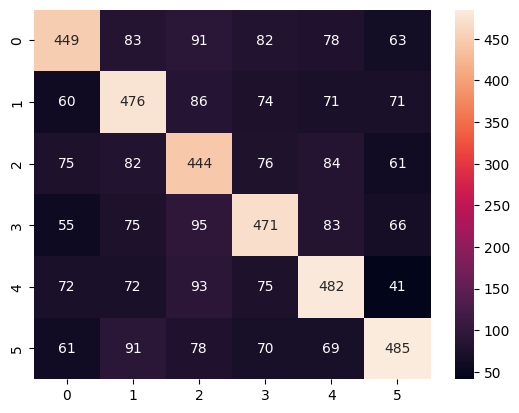

🏃 View run KNN StratifiedKFold=0 at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/20/runs/788ee00cbff14cd09ad752fa254bf6ed
🧪 View experiment at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/20
Accuracy: 0.5623015873015873
Precision: 0.5629319488522054
Recall: 0.5622573950968667
F1 Score: 0.5622742443126173
AUC Score: 0.814444557014129
              precision    recall  f1-score   support

       angry       0.57      0.55      0.56       846
        fear       0.56      0.53      0.55       838
       happy       0.54      0.58      0.56       822
     neutral       0.56      0.54      0.55       845
         sad       0.53      0.56      0.54       835
    surprise       0.62      0.60      0.61       854

    accuracy                           0.56      5040
   macro avg       0.56      0.56      0.56      5040
weighted avg       0.56      0.56      0.56      5040



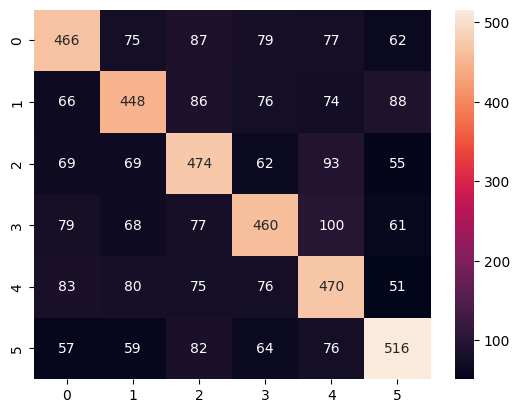

🏃 View run KNN StratifiedKFold=1 at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/20/runs/e65ad92affd74caca384dd02304bd172
🧪 View experiment at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/20
Accuracy: 0.5589285714285714
Precision: 0.5607842378541906
Recall: 0.5588182723571076
F1 Score: 0.559102080993732
AUC Score: 0.810224823283515
              precision    recall  f1-score   support

       angry       0.57      0.54      0.55       846
        fear       0.55      0.57      0.56       838
       happy       0.52      0.53      0.52       822
     neutral       0.59      0.57      0.58       845
         sad       0.51      0.58      0.55       835
    surprise       0.62      0.57      0.60       854

    accuracy                           0.56      5040
   macro avg       0.56      0.56      0.56      5040
weighted avg       0.56      0.56      0.56      5040



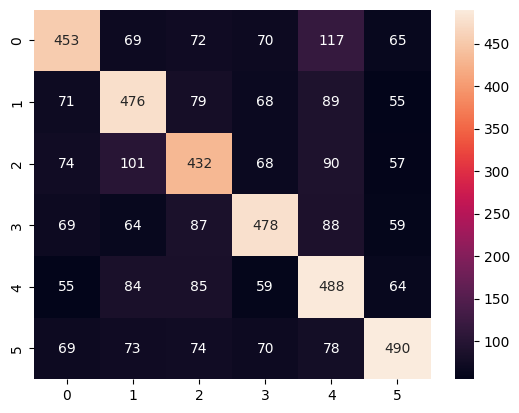

🏃 View run KNN StratifiedKFold=2 at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/20/runs/c9d62d4c620247b18c8cc03992c70891
🧪 View experiment at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/20
Accuracy: 0.551984126984127
Precision: 0.5524365283374763
Recall: 0.5518995273014095
F1 Score: 0.5519868522379784
AUC Score: 0.8062087309283495
              precision    recall  f1-score   support

       angry       0.53      0.51      0.52       846
        fear       0.55      0.56      0.55       838
       happy       0.51      0.54      0.52       822
     neutral       0.57      0.58      0.58       845
         sad       0.54      0.55      0.55       835
    surprise       0.61      0.57      0.59       854

    accuracy                           0.55      5040
   macro avg       0.55      0.55      0.55      5040
weighted avg       0.55      0.55      0.55      5040



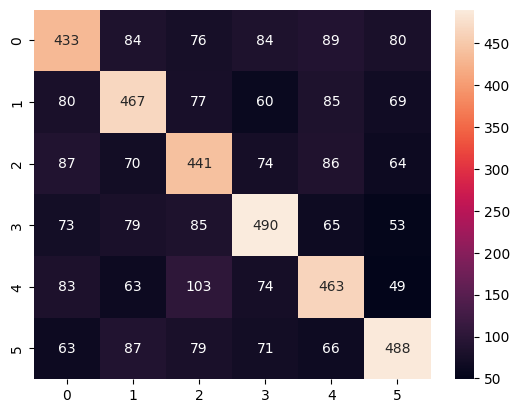

🏃 View run KNN StratifiedKFold=3 at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/20/runs/e4b64ac3e8144dc384ece20a9c949f47
🧪 View experiment at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/20
Accuracy: 0.5573412698412699
Precision: 0.5587382701890984
Recall: 0.5571711270524088
F1 Score: 0.557419887265349
AUC Score: 0.8111580625533176
              precision    recall  f1-score   support

       angry       0.57      0.58      0.57       846
        fear       0.53      0.54      0.54       838
       happy       0.57      0.53      0.55       822
     neutral       0.55      0.52      0.54       845
         sad       0.51      0.57      0.54       835
    surprise       0.63      0.59      0.61       854

    accuracy                           0.56      5040
   macro avg       0.56      0.56      0.56      5040
weighted avg       0.56      0.56      0.56      5040



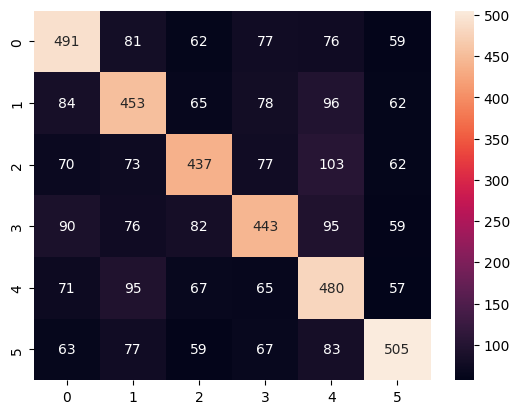

🏃 View run KNN StratifiedKFold=4 at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/20/runs/0f32e693943245f1a84c390533fbcda1
🧪 View experiment at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/20
Accuracy: 0.5601190476190476
Precision: 0.5611226401214521
Recall: 0.5599648518224203
F1 Score: 0.5602605230356533
AUC Score: 0.8099280918398707
              precision    recall  f1-score   support

       angry       0.55      0.57      0.56       846
        fear       0.58      0.55      0.56       838
       happy       0.57      0.55      0.56       822
     neutral       0.54      0.56      0.55       845
         sad       0.52      0.55      0.53       835
    surprise       0.61      0.59      0.60       854

    accuracy                           0.56      5040
   macro avg       0.56      0.56      0.56      5040
weighted avg       0.56      0.56      0.56      5040



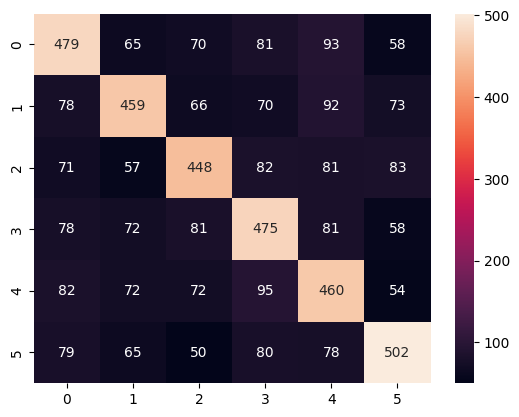

🏃 View run KNN StratifiedKFold=5 at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/20/runs/f6120f1f8a144136b32308f66c28ab4b
🧪 View experiment at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/20
Accuracy: 0.5599206349206349
Precision: 0.5599074980210266
Recall: 0.5596617379496044
F1 Score: 0.5597363968086868
AUC Score: 0.8118471015014653
              precision    recall  f1-score   support

       angry       0.58      0.57      0.58       846
        fear       0.55      0.55      0.55       838
       happy       0.53      0.53      0.53       822
     neutral       0.56      0.54      0.55       845
         sad       0.53      0.55      0.54       835
    surprise       0.62      0.61      0.62       854

    accuracy                           0.56      5040
   macro avg       0.56      0.56      0.56      5040
weighted avg       0.56      0.56      0.56      5040



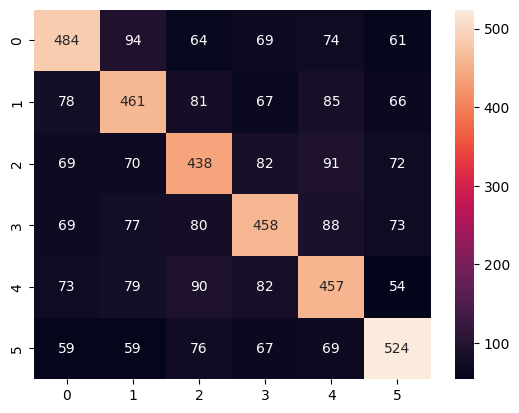

🏃 View run KNN StratifiedKFold=6 at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/20/runs/39ad951ccd1b40349616bedd5256ab97
🧪 View experiment at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/20
Accuracy: 0.5615079365079365
Precision: 0.5616382167131238
Recall: 0.5613570932098781
F1 Score: 0.5613234588002686
AUC Score: 0.8124318329656771
              precision    recall  f1-score   support

       angry       0.58      0.54      0.56       846
        fear       0.56      0.55      0.55       838
       happy       0.53      0.56      0.55       822
     neutral       0.57      0.56      0.57       845
         sad       0.53      0.54      0.53       835
    surprise       0.60      0.61      0.61       854

    accuracy                           0.56      5040
   macro avg       0.56      0.56      0.56      5040
weighted avg       0.56      0.56      0.56      5040



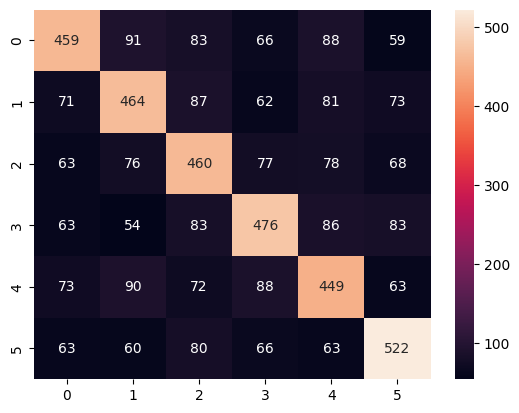

🏃 View run KNN StratifiedKFold=7 at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/20/runs/d93dad07fa2a46a48ec870f6bfcd892b
🧪 View experiment at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/20
Accuracy: 0.5515873015873016
Precision: 0.5542135278414045
Recall: 0.5515323690671535
F1 Score: 0.552105508553234
AUC Score: 0.8029395856303267
              precision    recall  f1-score   support

       angry       0.59      0.54      0.56       846
        fear       0.52      0.56      0.54       838
       happy       0.52      0.54      0.53       822
     neutral       0.55      0.56      0.55       845
         sad       0.51      0.55      0.53       835
    surprise       0.63      0.56      0.59       854

    accuracy                           0.55      5040
   macro avg       0.55      0.55      0.55      5040
weighted avg       0.55      0.55      0.55      5040



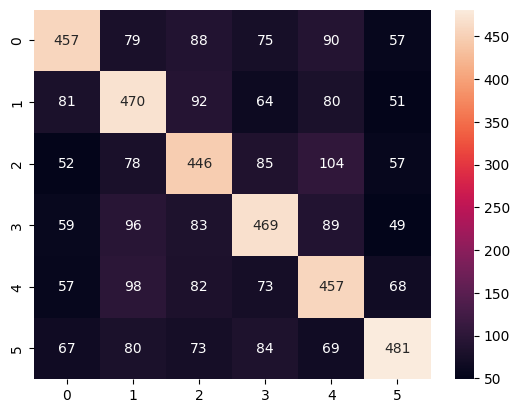

🏃 View run KNN StratifiedKFold=8 at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/20/runs/4c90728304604f6dbc075608bc196218
🧪 View experiment at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/20
Accuracy: 0.5563492063492064
Precision: 0.5568135196327187
Recall: 0.5561890211712309
F1 Score: 0.5561116159232093
AUC Score: 0.8140770592489986
              precision    recall  f1-score   support

       angry       0.57      0.51      0.54       846
        fear       0.53      0.55      0.54       838
       happy       0.53      0.56      0.54       822
     neutral       0.56      0.55      0.56       845
         sad       0.52      0.54      0.53       835
    surprise       0.63      0.63      0.63       854

    accuracy                           0.56      5040
   macro avg       0.56      0.56      0.56      5040
weighted avg       0.56      0.56      0.56      5040



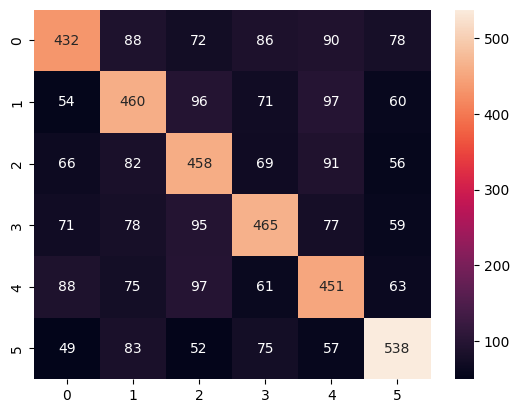

🏃 View run KNN StratifiedKFold=9 at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/20/runs/f32cf13cb55a427c88e6ae7bac232959
🧪 View experiment at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/20


In [27]:
images = np.load('C:\\Users\\vinar\\Downloads\\gabor-filtered-imgs\\FER2013\\combined\\images.npy')
labels = np.load('C:\\Users\\vinar\\Downloads\\gabor-filtered-imgs\\FER2013\\combined\\labels.npy')

N_NEIGHBORS = 3
WEIGHTS = 'distance'
METRIC = 'manhattan'
ALGORITHM = 'auto'
TEST_SIZE = 0.7
RANDOM_STATE = 42
N_SPLITS = 10
SHUFFLE = True

model_params = {
  'n_neighbors': N_NEIGHBORS,
  'weights': WEIGHTS,
  'metric': METRIC,
  'algorithm': ALGORITHM
}

calib_params = {
  'test_size': TEST_SIZE,
  'random_state': RANDOM_STATE
}

kfold_params = {
    'n_splits': N_SPLITS,
    'shuffle': SHUFFLE
}

skf = StratifiedKFold(**kfold_params)
i = 0

for train_idx, test_idx in skf.split(images, labels):
  X_train, X_test = images[train_idx], images[test_idx]
  y_train, y_test = labels[train_idx], labels[test_idx]

  X_calib, X_test, y_calib, y_test = train_test_split(X_test, y_test, **calib_params)

  model = KNeighborsClassifier(**model_params)
  model.fit(X_train, y_train)

  calib_model = CalibratedClassifierCV(model, cv="prefit")
  calib_model.fit(X_calib, y_calib)

  predict = calib_model.predict(X_test)
  predict_proba = calib_model.predict_proba(X_test)

  metrics = {
    'accuracy': accuracy_score(y_test, predict),
    'precision': precision_score(y_test, predict, average='macro'),
    'recall': recall_score(y_test, predict, average='macro'),
    'f1': f1_score(y_test, predict, average='macro'),
    'auc_score': roc_auc_score(y_test, predict_proba, multi_class='ovr', average='macro')
  }

  print(f"Accuracy: {metrics['accuracy']}\nPrecision: {metrics['precision']}\nRecall: {metrics['recall']}\nF1 Score: {metrics['f1']}\nAUC Score: {metrics['auc_score']}")
  report = classification_report(y_test, predict)
  print(report)

  cm = confusion_matrix(y_test, predict)
  sns.heatmap(cm, annot=True, fmt='d')
  plt.savefig('confusion_matrix.png')
  plt.show()

  mlflow.set_experiment("KNN_Model FER2013 augmented without disgust")
  mlflow.set_tracking_uri("https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow")

  with mlflow.start_run(run_name=f'KNN StratifiedKFold={i}'):
    mlflow.log_artifact('confusion_matrix.png')
    mlflow.log_params(gabor_params)
    mlflow.log_params(calib_params)
    mlflow.log_params(model_params)
    mlflow.log_params(kfold_params)
    mlflow.log_param('floating_point', FLOATING_POINT)
    mlflow.log_param('image_size', IMAGE_SIZE)
    mlflow.log_param('PCA_n_components', N_COMPONENTS)
    mlflow.log_param('gaussian_blur', BLUR)
    mlflow.log_metrics(metrics)
    mlflow.sklearn.log_model(
        sk_model=calib_model,
        artifact_path='KNN Model',
        input_example=X_train[:1]
    )
  i = i + 1

## **Testing images shape**

In [62]:
images_ = []
# img = cv.imread(f'facial-emotion-recognition-augmented/disgust/disgust_1022.png', cv.IMREAD_GRAYSCALE)
# img = cv.imread(f'C:\\Users\\vinar\\Downloads\\RAF-DB\\test\\fear\\test_2253_aligned.jpg', cv.IMREAD_GRAYSCALE)
img = cv.imread(f'../neutral_3.png', cv.IMREAD_GRAYSCALE)
img = cv.resize(img, IMAGE_SIZE)
img = cv.GaussianBlur(img,BLUR,0)
img = cv.equalizeHist(img)
face_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(50, 50))

if len(faces) > 0:
    x, y, w, h = faces[0]
    img = img[y:y+h, x:x+w]
else:
    h, w = img.shape[:2]
    crop_size = min(h, w)
    x = (w - crop_size) // 2
    y = (h - crop_size) // 2
    img = img[y:y+crop_size, x:x+crop_size]
    
img = cv.copyMakeBorder(
        img, 
    10, 10, 10, 10,
    cv.BORDER_CONSTANT, 
    value=(0, 0, 0)
    )
    
img = cv.resize(img, IMAGE_SIZE)
img = img / 255.0
img = gabor_filter(img)

img = img.reshape(img.shape[0], -1)
pca = PCA(n_components=N_COMPONENTS_LOCAL)
img = pca.fit_transform(img)
images_.append(img)
images_ = np.array(images_)

images_ = images_.reshape(images_.shape[0], -1)
with open('pca_model.pkl', 'rb') as f:
    loaded_pca = pickle.load(f)
images_ = loaded_pca.transform(images_)

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative explained variance:", np.cumsum(pca.explained_variance_ratio_))

print(images_.shape)

Explained variance ratio: [6.93638206e-01 1.44229040e-01 1.19399264e-01 1.99876968e-02
 1.34240380e-02 4.39847866e-03 3.95477749e-03 5.30273886e-04
 2.62358924e-04 9.53739509e-05 7.00293822e-05 7.09255119e-06
 2.18500873e-06 1.06415473e-06 3.07617142e-07 3.35157289e-08]
Cumulative explained variance: [0.6936382  0.83786726 0.9572665  0.9772542  0.99067825 0.9950767
 0.9990315  0.9995618  0.99982417 0.99991953 0.99998957 0.99999666
 0.99999887 0.99999994 1.0000002  1.0000002 ]
(1, 6)


In [28]:
logged_model = 'runs:/5824ce98ca7a4a508f7623fe39881ce1/KNN Model'
model = mlflow.pyfunc.load_model(logged_model)

In [63]:
prediction = model.predict(images_)
for p in prediction:
  print(p)

sad


## **Tuning**

### **Without PCA**

In [64]:
images = np.load('C:\\Users\\vinar\\Downloads\\gabor-filtered-imgs\\FER2013\\combined\\images.npy')
labels = np.load('C:\\Users\\vinar\\Downloads\\gabor-filtered-imgs\\FER2013\\combined\\labels.npy')

N_NEIGHBORS = [3,5,7,9,11]
WEIGHTS = ['uniform', 'distance']
METRIC = ['minkowski', 'euclidean', 'manhattan']
ALGORITHM = ['auto', 'ball_tree', 'kd_tree', 'brute']

TEST_SIZE = 0.2
RANDOM_STATE = 42

split_params = {
    'test_size': TEST_SIZE,
    'random_state': RANDOM_STATE
}

model_params = {
    'n_neighbors': N_NEIGHBORS,
    'weights': WEIGHTS,
    'metric': METRIC,
    'algorithm': ALGORITHM
}

scoring = {
    'accuracy': 'accuracy',
    # 'roc_auc': 'roc_auc'
}

X_train, X_test, y_train, y_test = train_test_split(images, labels, **split_params, stratify=labels)
# X_test, X_calib, y_test, y_calib = train_test_split(X_test, y_test, **calib_params, stratify=y_test)

model = KNeighborsClassifier()
grid = GridSearchCV(
    estimator=model, 
    param_grid=model_params,
    scoring=scoring,
    refit='accuracy',
    cv=3,
    verbose=2
)
grid.fit(X_train, y_train)

print(grid.best_estimator_)
print(grid.best_params_)

Fitting 3 folds for each of 120 candidates, totalling 360 fits
[CV] END algorithm=auto, metric=minkowski, n_neighbors=3, weights=uniform; total time=   0.6s
[CV] END algorithm=auto, metric=minkowski, n_neighbors=3, weights=uniform; total time=   0.6s
[CV] END algorithm=auto, metric=minkowski, n_neighbors=3, weights=uniform; total time=   0.5s
[CV] END algorithm=auto, metric=minkowski, n_neighbors=3, weights=distance; total time=   0.1s
[CV] END algorithm=auto, metric=minkowski, n_neighbors=3, weights=distance; total time=   0.1s
[CV] END algorithm=auto, metric=minkowski, n_neighbors=3, weights=distance; total time=   0.1s
[CV] END algorithm=auto, metric=minkowski, n_neighbors=5, weights=uniform; total time=   0.5s
[CV] END algorithm=auto, metric=minkowski, n_neighbors=5, weights=uniform; total time=   0.6s
[CV] END algorithm=auto, metric=minkowski, n_neighbors=5, weights=uniform; total time=   0.6s
[CV] END algorithm=auto, metric=minkowski, n_neighbors=5, weights=distance; total time= 

d:\PythonProject\env\Lib\site-packages\sklearn\model_selection\_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\PythonProject\env\Lib\site-packages\sklearn\metrics\_scorer.py", line 139, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "d:\PythonProject\env\Lib\site-packages\sklearn\metrics\_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "d:\PythonProject\env\Lib\site-packages\sklearn\metrics\_scorer.py", line 89, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "d:\PythonProject\env\Lib\site-packages\sklearn\utils\_response.py", line 211, in _get_response_values
    y_pred = prediction_method(X)
             ^^^^^^^^^^^^^^^^^^^^
  File "d:\PythonProject\env\Lib\site-packages\sklearn\neighbors\_classification.py", line 259, in pred

[CV] END algorithm=brute, metric=manhattan, n_neighbors=3, weights=distance; total time=   1.2s
[CV] END algorithm=brute, metric=manhattan, n_neighbors=3, weights=distance; total time=   1.2s
[CV] END algorithm=brute, metric=manhattan, n_neighbors=3, weights=distance; total time=   1.2s
[CV] END algorithm=brute, metric=manhattan, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, metric=manhattan, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, metric=manhattan, n_neighbors=5, weights=uniform; total time=   0.0s


d:\PythonProject\env\Lib\site-packages\sklearn\model_selection\_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\PythonProject\env\Lib\site-packages\sklearn\metrics\_scorer.py", line 139, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "d:\PythonProject\env\Lib\site-packages\sklearn\metrics\_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "d:\PythonProject\env\Lib\site-packages\sklearn\metrics\_scorer.py", line 89, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "d:\PythonProject\env\Lib\site-packages\sklearn\utils\_response.py", line 211, in _get_response_values
    y_pred = prediction_method(X)
             ^^^^^^^^^^^^^^^^^^^^
  File "d:\PythonProject\env\Lib\site-packages\sklearn\neighbors\_classification.py", line 259, in pred

[CV] END algorithm=brute, metric=manhattan, n_neighbors=5, weights=distance; total time=   1.2s
[CV] END algorithm=brute, metric=manhattan, n_neighbors=5, weights=distance; total time=   1.2s
[CV] END algorithm=brute, metric=manhattan, n_neighbors=5, weights=distance; total time=   1.3s
[CV] END algorithm=brute, metric=manhattan, n_neighbors=7, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, metric=manhattan, n_neighbors=7, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, metric=manhattan, n_neighbors=7, weights=uniform; total time=   0.0s


d:\PythonProject\env\Lib\site-packages\sklearn\model_selection\_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\PythonProject\env\Lib\site-packages\sklearn\metrics\_scorer.py", line 139, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "d:\PythonProject\env\Lib\site-packages\sklearn\metrics\_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "d:\PythonProject\env\Lib\site-packages\sklearn\metrics\_scorer.py", line 89, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "d:\PythonProject\env\Lib\site-packages\sklearn\utils\_response.py", line 211, in _get_response_values
    y_pred = prediction_method(X)
             ^^^^^^^^^^^^^^^^^^^^
  File "d:\PythonProject\env\Lib\site-packages\sklearn\neighbors\_classification.py", line 259, in pred

[CV] END algorithm=brute, metric=manhattan, n_neighbors=7, weights=distance; total time=   1.2s
[CV] END algorithm=brute, metric=manhattan, n_neighbors=7, weights=distance; total time=   1.3s
[CV] END algorithm=brute, metric=manhattan, n_neighbors=7, weights=distance; total time=   1.2s
[CV] END algorithm=brute, metric=manhattan, n_neighbors=9, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, metric=manhattan, n_neighbors=9, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, metric=manhattan, n_neighbors=9, weights=uniform; total time=   0.0s


d:\PythonProject\env\Lib\site-packages\sklearn\model_selection\_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\PythonProject\env\Lib\site-packages\sklearn\metrics\_scorer.py", line 139, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "d:\PythonProject\env\Lib\site-packages\sklearn\metrics\_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "d:\PythonProject\env\Lib\site-packages\sklearn\metrics\_scorer.py", line 89, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "d:\PythonProject\env\Lib\site-packages\sklearn\utils\_response.py", line 211, in _get_response_values
    y_pred = prediction_method(X)
             ^^^^^^^^^^^^^^^^^^^^
  File "d:\PythonProject\env\Lib\site-packages\sklearn\neighbors\_classification.py", line 259, in pred

[CV] END algorithm=brute, metric=manhattan, n_neighbors=9, weights=distance; total time=   1.2s
[CV] END algorithm=brute, metric=manhattan, n_neighbors=9, weights=distance; total time=   1.3s
[CV] END algorithm=brute, metric=manhattan, n_neighbors=9, weights=distance; total time=   1.4s
[CV] END algorithm=brute, metric=manhattan, n_neighbors=11, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, metric=manhattan, n_neighbors=11, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, metric=manhattan, n_neighbors=11, weights=uniform; total time=   0.0s


d:\PythonProject\env\Lib\site-packages\sklearn\model_selection\_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\PythonProject\env\Lib\site-packages\sklearn\metrics\_scorer.py", line 139, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "d:\PythonProject\env\Lib\site-packages\sklearn\metrics\_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "d:\PythonProject\env\Lib\site-packages\sklearn\metrics\_scorer.py", line 89, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "d:\PythonProject\env\Lib\site-packages\sklearn\utils\_response.py", line 211, in _get_response_values
    y_pred = prediction_method(X)
             ^^^^^^^^^^^^^^^^^^^^
  File "d:\PythonProject\env\Lib\site-packages\sklearn\neighbors\_classification.py", line 259, in pred

[CV] END algorithm=brute, metric=manhattan, n_neighbors=11, weights=distance; total time=   1.3s
[CV] END algorithm=brute, metric=manhattan, n_neighbors=11, weights=distance; total time=   1.3s
[CV] END algorithm=brute, metric=manhattan, n_neighbors=11, weights=distance; total time=   1.4s
KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')
{'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


d:\PythonProject\env\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [0.27685764 0.35449653 0.26064236 0.34545139 0.25310764 0.34302083
 0.24833333 0.34069444 0.24175347 0.33831597 0.27685764 0.35449653
 0.26064236 0.34545139 0.25310764 0.34302083 0.24833333 0.34069444
 0.24175347 0.33831597 0.27930556 0.35598958 0.26265625 0.34842014
 0.25359375 0.34527778 0.24909722 0.34168403 0.24223958 0.33932292
 0.27685764 0.35449653 0.26064236 0.34545139 0.25310764 0.34302083
 0.24833333 0.34069444 0.24175347 0.33831597 0.27685764 0.35449653
 0.26064236 0.34545139 0.25310764 0.34302083 0.24833333 0.34069444
 0.24175347 0.33831597 0.27930556 0.35598958 0.26265625 0.34842014
 0.25359375 0.34527778 0.24907986 0.34168403 0.24223958 0.33932292
 0.27685764 0.35449653 0.26064236 0.34545139 0.25310764 0.34302083
 0.24833333 0.34069444 0.24175347 0.33831597 0.27685764 0.35449653
 0.26064236 0.34545139 0.25310764 0.34302083 0.24833333 

### **Using calibration**

In [21]:
images = np.load('C:\\Users\\vinar\\Downloads\\gabor-filtered-imgs\\FER2013\\combined\\images.npy')
labels = np.load('C:\\Users\\vinar\\Downloads\\gabor-filtered-imgs\\FER2013\\combined\\labels.npy')

N_NEIGHBORS = 3
WEIGHTS = 'distance'
METRIC = 'manhattan'
ALGORITHM = 'auto'

TEST_SIZE = 0.2
CALIB_SIZE = 0.5
RANDOM_STATE = 42

split_params = {
    'test_size': TEST_SIZE,
    'random_state': RANDOM_STATE
}

calib_params = {
    'test_size': CALIB_SIZE,
    'random_state': RANDOM_STATE
}

X_train, X_test, y_train, y_test = train_test_split(images, labels, **split_params, stratify=labels)
X_test, X_calib, y_test, y_calib = train_test_split(X_test, y_test, **calib_params, stratify=y_test)

model_params = {
  'n_neighbors': N_NEIGHBORS,
  'weights': WEIGHTS,
  'metric': METRIC,
  'algorithm': ALGORITHM
}

model = KNeighborsClassifier(**model_params)
model.fit(X_train, y_train)

calib_model = CalibratedClassifierCV(model, cv="prefit")
calib_model.fit(X_calib, y_calib)

predict = calib_model.predict(X_test)
predict_proba = calib_model.predict_proba(X_test)

metrics = {
  'accuracy': accuracy_score(y_test, predict),
  'precision': precision_score(y_test, predict, average='macro'),
  'recall': recall_score(y_test, predict, average='macro'),
  'f1': f1_score(y_test, predict, average='macro'),
  'auc_score': roc_auc_score(y_test, predict_proba, multi_class='ovr', average='macro')
}

print(f"Accuracy: {metrics['accuracy']}\nPrecision: {metrics['precision']}\nRecall: {metrics['recall']}\nF1 Score: {metrics['f1']}\nROC_AUC Score: {metrics['auc_score']}")
print(classification_report(y_test, predict))

# mlflow.set_experiment("KNN_Model using calibration")
# mlflow.set_tracking_uri("https://dagshub.com/IdjiotSandwiches/knn-fer.mlflow")

# with mlflow.start_run(run_name=f'KNN sigma=5'):
#   mlflow.log_params(gabor_params)
#   mlflow.log_params(split_params)
#   mlflow.log_param('calib_test_size', calib_params['test_size'])
#   mlflow.log_param('calib_random_state', calib_params['random_state'])
#   mlflow.log_params(model_params)
#   mlflow.log_metrics(metrics)
#   mlflow.sklearn.log_model(
#       sk_model=calib_model,
#       artifact_path='KNN Model',
#       input_example=X_train[:1]
#   )

Accuracy: 0.5416666666666666
Precision: 0.5417140401524803
Recall: 0.5416666666666667
F1 Score: 0.5416503174348996
ROC_AUC Score: 0.799350162037037
              precision    recall  f1-score   support

       angry       0.54      0.53      0.53      1200
        fear       0.52      0.53      0.53      1200
       happy       0.54      0.53      0.53      1200
     neutral       0.55      0.54      0.54      1200
         sad       0.54      0.54      0.54      1200
    surprise       0.57      0.58      0.58      1200

    accuracy                           0.54      7200
   macro avg       0.54      0.54      0.54      7200
weighted avg       0.54      0.54      0.54      7200



### **Tuning k Value**

In [65]:
images = np.load('C:\\Users\\vinar\\Downloads\\gabor-filtered-imgs\\images.npy')
labels = np.load('C:\\Users\\vinar\\Downloads\\gabor-filtered-imgs\\labels.npy')

N_NEIGHBORS = range(1,21)
WEIGHTS = 'distance'
METRIC = 'manhattan'
ALGORITHM = 'ball_tree'
TEST_SIZE = 0.5
RANDOM_STATE = 42
N_SPLITS = 10
SHUFFLE = True

X_train, X_test, y_train, y_test = train_test_split(images, labels, random_state=RANDOM_STATE, test_size=0.2)

def evaluate_knn(k):
    model_params = {
        'n_neighbors': k,
        'weights': WEIGHTS,
        'metric': METRIC,
        'algorithm': ALGORITHM
    }
    model = KNeighborsClassifier(**model_params)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    return cv_scores.mean()

# Parallel execution
scores = Parallel(n_jobs=4)(delayed(evaluate_knn)(k) for k in N_NEIGHBORS)

# Find optimal k
optimal_k = N_NEIGHBORS[scores.index(max(scores))]
print(f"Optimal k: {optimal_k}")

Optimal k: 1


## **Prediction result**

In [52]:
not_same = []

for p, y in zip(predict, y_test):
  if(p != y):
    not_same.append(p)

print(len(not_same))

1120
